## MFA System

### General points

- `FlodymArray` and `Stock` objects work without `MFASystem`

- Advantages of `MFASystem`:
  - Having all attributes in one namespace, including the "parent" dimension set.
  - Integrated data read-in
  - More export and plotting
  - Checks for `NaN` values and mass-balance

- Different ways / levels of integration for setup & data read-in
  - Shown here: suggested one

- Quite some code needed, only to show rough principle

### Attributes

- `dims` (`DimensionSet`)
- dictionaries:
  - `flows` (name: `Flow`)
  - `stocks` (name: `Stock`)
  - `processes` (name: `Process`*)
  - `parameters`  (name: `Parameter`)

### Three ingredients for MFA System

- System Definition
  - Which dimensions and processes are there?
  - Which flows, parameters, stocks are there?
    - Which dimensions do they have?
- Data input from files
  - dimension items (which years, regions, ...)
  - parameter values
- Compute routine

### Definition

In [1]:
import flodym as fd

dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [2]:
parameter_definitions = [
    fd.ParameterDefinition(name="dewatering share to fibers", dim_letters=("s",)),
    fd.ParameterDefinition(name="manure composition", dim_letters=("s",)),
]

In [3]:
process_names = [
    "sysenv",
    "dewatering",
    "storage"
]

In [4]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
]

In [5]:
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        #process="use",
        dim_letters=('s',),
        time_letter='s',
        subclass=fd.SimpleFlowDrivenStock,
        #lifetime_model_class=fd.LogNormalLifetime,
    ),
]

In [6]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

### Data sources 

- Only give the locations

In [7]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
}

# file contents as format example
print(open("data/dimension_substance.csv", "r").read())

dry matter
water



In [8]:
parameter_files = {
    "dewatering share to fibers": "data/parameter_dewatering_share_to_fibers.csv",
    "manure composition": "data/parameter_manure_composition.csv",
}

# file contents as format example
print(open("data/parameter_manure_composition.csv", "r").read())

substance, value
dry matter,0.1
water,0.9



### Compute routine: Write your own subclass

- Flodym provides `MFASystem` parent class (a pydantic `BaseModel`)
- Subclass should implement individual `compute` function
  - Has to be consistent with the flows, stocks, and parameters
- The rest is up to you (sub-functions etc)

In [9]:
class SimpleMFA(fd.MFASystem):
    def compute(self):

        # manufacturing flows
        self.flows["sysenv => dewatering"][...] = self.parameters["manure composition"]
        self.flows["dewatering => sysenv"][...] = self.flows["sysenv => dewatering"] * self.parameters["dewatering share to fibers"]
        self.flows['dewatering => storage'][...] = self.flows['sysenv => dewatering'] * (1 - self.parameters["dewatering share to fibers"])
        self.flows['storage => sysenv'][...] = self.flows['dewatering => storage']

        '''
        # use stock
        self.stocks["use"].inflow[...] = self.flows["manufacturing => use"][...]
        self.stocks["use"].lifetime_model.set_prms(
            mean=self.parameters["product lifetimes"],
            std=0.5*self.parameters["product lifetimes"],
        )
        self.stocks["use"].compute()
        
        # end-of-life  flow
        self.flows["use => sysenv"][...] = self.stocks["use"].outflow
        ''';

- notice the automatic flow naming (this is customizable) 

### Init, load & compute

In [10]:
mfa_example = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [11]:
mfa_example.compute()

In [12]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


### Sankey Plotting

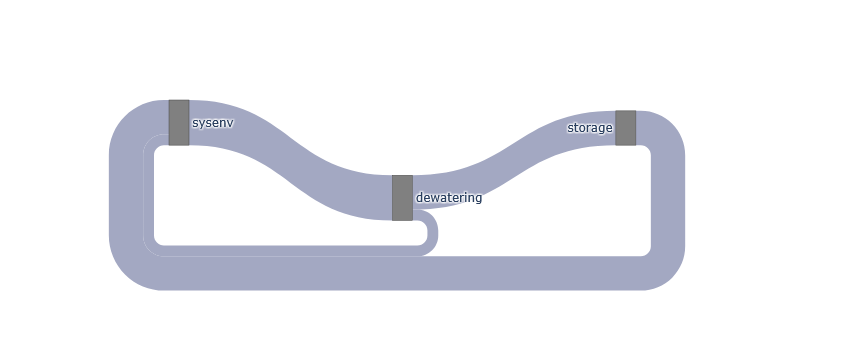

In [13]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_example, exclude_processes=[]).plot()
fig.show()

### Alternative Setup

Less simple, more customizable
- Completely manual
  - Create dimension set yourself
  - Create all dictionaries (processes, flows, stocks, parameters) yourself
  - Pass to class init
- Semi-manual
  - Create dimension set yourself
  - Use `make_processes`
  - Use `make_empty_flows` and `make_empty_stocks`
  - Create parameter dict yourself
- Advanced
  - Write your own reader and use `MFASystem.from_definition()`

### Brightway implementation

In [14]:
import bw2data as bd

17:51:22+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [15]:
bd.projects.set_current("manure")

In [26]:
name = 'manure'
if name in bd.databases:
    del bd.databases[name]
    db = bd.Database(name)
    db.register()
bd.databases

Databases dictionary with 1 object(s):
	manure

In [ ]:
functional_unit = db.new_node(
    name='functional unit',
    unit='ton',
    

In [20]:
ecoinvent_el = mfa_example.flows['sysenv => dewatering']['dry matter'].value

0.1


In [ ]:
node {
    name: electricity
    exchanges:
        el:
            amount: ecoinvent_el
}

